In [1]:
# mounting the dataset for google collab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Importing the library
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
#importing the dataset 
data_dir = '/content/drive/My Drive/Labelled'
#printing total number of images
from glob import glob
images = glob(os.path.join(data_dir, '*/*.jpg'))
tot_images = len(images)
print('Total images:', tot_images)

# Define transforms for the training and validation sets
data_transforms ={
    "train_transforms": transforms.Compose([transforms.RandomRotation(30),
                                           transforms.RandomResizedCrop(224), 
                                           transforms.RandomHorizontalFlip(), 
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406], 
                                                                [0.229, 0.224, 0.225])]),
   "valid_transforms": transforms.Compose([transforms.Resize(225),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])]), 
    "test_transforms": transforms.Compose([transforms.Resize(225),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])
}

Total images: 3365


In [4]:
# Split the dataset into train, validation and test
train_data = 0.8
valid_data = 0.1
test_data = 0.1

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(data_dir, transform=data_transforms["train_transforms"])
valid_data = datasets.ImageFolder(data_dir, transform=data_transforms["valid_transforms"])
test_data = datasets.ImageFolder(data_dir, transform=data_transforms["test_transforms"])

# Obtain training indices that will be used for validation and test
num_train = len(train_data)
indices = list(range(num_train))
# np.random.shuffle(indices)
train_count = int(0.8*num_train)
valid_count = int(0.1*num_train)
test_count = num_train - train_count - valid_count
train_idx = indices[:train_count]
valid_idx = indices[train_count:train_count+valid_count]
test_idx = indices[train_count+valid_count:]

print(len(train_idx), len(valid_idx), len(test_idx))
print("Training", train_count, np.sum(len(train_idx)/num_train))
print("Validation", valid_count, np.sum(len(valid_idx)/num_train))
print("Test", test_count, np.sum(len(test_idx)/num_train))

# Define a custom sampler for the dataset loader avoiding recreating the dataset (just creating a new loader for each different sampling)
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Define the dataloaders using the image datasets. Dataloader is used to load our data in batches
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = 32, sampler = valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 32, sampler = test_sampler)



2692 336 337
Training 2692 0.8
Validation 336 0.099851411589896
Test 337 0.10014858841010402


In [5]:
classes=['LeafBlast', 'BrownSpot', 'Healthy', 'Hispa']

In [7]:

# Loading the pretrained model from pytorch's library and storing it
model_transfer = models.googlenet(pretrained=True)

use_cuda = torch.cuda.is_available()
if use_cuda:
    model_transfer = model_transfer.cuda()
for param in model_transfer.parameters():
    param.requires_grad=True    
# Define n_inputs takes the same number of inputs from pre-trained model
n_inputs = model_transfer.fc.in_features 

# Add last linear layer as we have 4 classes
last_layer = nn.Linear(n_inputs, len(classes))

model_transfer.fc = last_layer

if use_cuda:
    model_transfer = model_transfer.cuda()
  
# Check to see the last layer produces the expected number of outputs
print(model_transfer.fc.out_features)

# Specify loss function and optimizer and number of epoch
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.001, momentum=0.9)
epoch_num=40


4


In [8]:
train_loss_list=[]
valid_loss_list=[]
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    '''returns trained model'''
    # Initialize tracker for minimum validation loss
    valid_loss_min = np.inf
  
    for epoch in range(1, n_epochs+1):
        
        # Initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
    
        # Model training
        model.train()
        for batch_idx, (data,target) in enumerate(trainloader):
            # 1st step: Move to GPU
            if use_cuda:
                data,target = data.cuda(), target.cuda()
      
            
            optimizer.zero_grad()
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Perform the Cross Entropy Loss. Calculate the batch loss.
            loss = criterion(output, target)
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Perform optimization step (parameter update)
            optimizer.step()
            # Record the average training loss
            train_loss = train_loss + ((1/ (batch_idx + 1 ))*(loss.data-train_loss))
      
        # Model validation
        model.eval()
        for batch_idx, (data,target) in enumerate(validloader):
            # Move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # Update the average validation loss
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Calculate the batch loss
            loss = criterion(output, target)
            # Update the average validation loss
            valid_loss = valid_loss + ((1/ (batch_idx +1)) * (loss.data - valid_loss))
        print('Epoch: {} \tTraining Loss: {:.5f} \tValidation Loss: {:.5f}'.format(
            epoch,
            train_loss,
            valid_loss))
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        
    
        # Save the model if the validation loss has decreased
        if valid_loss <= valid_loss_min:
            #print('Validation loss decreased ({:.5f} --> {:.5f}). Saving model ...'.format(
                  #valid_loss_min,
                  #valid_loss))
            print("Saving the model as validation loss is decreased")      
            torch.save(model.state_dict(), 'model_transfer.pt')
            valid_loss_min = valid_loss
  
    # Return trained model
    return model

# Define loaders transfer
loaders_transfer = {'train': trainloader,
                    'valid': validloader,
                    'test': testloader}

# Train the model
model_transfer = train(epoch_num, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')     

Epoch: 1 	Training Loss: 1.26762 	Validation Loss: 1.39176
Saving the model as validation loss is decreased
Epoch: 2 	Training Loss: 1.10001 	Validation Loss: 1.16452
Saving the model as validation loss is decreased
Epoch: 3 	Training Loss: 0.98740 	Validation Loss: 1.19394
Epoch: 4 	Training Loss: 0.90804 	Validation Loss: 1.06550
Saving the model as validation loss is decreased
Epoch: 5 	Training Loss: 0.82333 	Validation Loss: 0.91896
Saving the model as validation loss is decreased
Epoch: 6 	Training Loss: 0.78421 	Validation Loss: 0.86594
Saving the model as validation loss is decreased
Epoch: 7 	Training Loss: 0.75031 	Validation Loss: 1.09209
Epoch: 8 	Training Loss: 0.72938 	Validation Loss: 0.88551
Epoch: 9 	Training Loss: 0.70671 	Validation Loss: 0.94713
Epoch: 10 	Training Loss: 0.70097 	Validation Loss: 0.80471
Saving the model as validation loss is decreased
Epoch: 11 	Training Loss: 0.67816 	Validation Loss: 0.81665
Epoch: 12 	Training Loss: 0.65764 	Validation Loss: 0.7

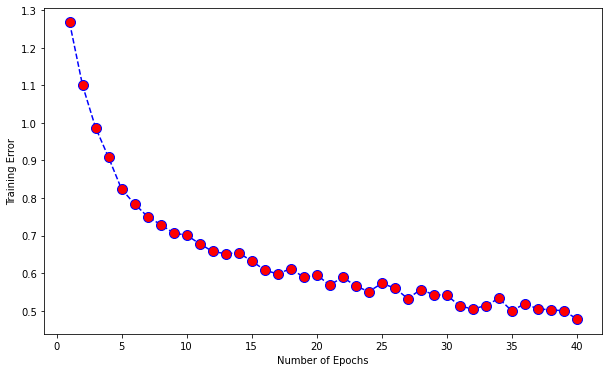

In [9]:
#visualising the training Error
plt.figure(figsize = (10, 6))  
plt.plot(range(1, epoch_num +1, 1), train_loss_list, color ='blue', linestyle ='dashed', marker ='o', 
         markerfacecolor ='red', markersize = 10) 
plt.xlabel('Number of Epochs')  
plt.ylabel('Training Error')  
plt.show()

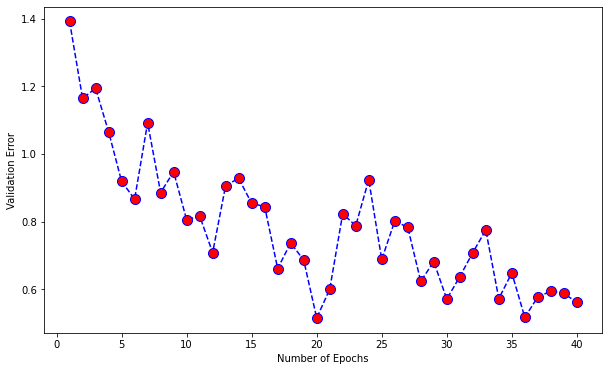

In [10]:
#visualising the validation error
plt.figure(figsize = (10, 6))  
plt.plot(range(1,epoch_num+1, 1), valid_loss_list, color ='blue', linestyle ='dashed', marker ='o', 
         markerfacecolor ='red', markersize = 10) 
plt.xlabel('Number of Epochs')  
plt.ylabel('Validation Error')  
plt.show()

In [11]:
# Load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

In [12]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0
    total = 0

    model_transfer.eval() #set model into evaluation/testing mode. It turns of drop off layer
    #Iterating over test data
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to 
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% ' % (
        100. * correct / total))
    print('\nTotal {} correct Prediction out of {} '.format(correct,total))
    print('\nTotal {} wrong Prediction out of {} '.format(total-correct,total))


# call test function    
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.194623


Test Accuracy: 93% 

Total 314 correct Prediction out of 337 

Total 23 wrong Prediction out of 337 
